In [2]:
import pandas as pd
from biopandas.pdb import PandasPdb
from prody import parsePDBHeader
from typing import Optional
import numpy as np
import time
import matplotlib.pyplot as plt

In [4]:
def f1(x):
    return x ** -1

In [5]:
def f1_5(x):
    return x ** -1.5

In [6]:
def f2(x):
    return x ** -2

In [7]:
def f2_5(x):
    return x ** -2.5

In [8]:
def f3(x):
    return x ** -3

In [ ]:
def preprocess(pdb_path, feature, include='none', exclude='none'):
    atomic_df = PandasPdb().read_pdb(pdb_path)

    header = parsePDBHeader(pdb_path)

    atomic_df = atomic_df.get_model(1)
    
    if include != 'none':
        for ind, i in enumerate(include):
            if ind == 0:
                temp = atomic_df.df['ATOM'][feature].eq(i)
            else:
                temp = temp | atomic_df.df['ATOM'][feature].eq(i)

        atomic_df.df['ATOM'] = atomic_df.df['ATOM'][temp]

    # return atomic_df.df['ATOM']

    atomic_df.to_pdb('pdbs/preprocessed/' + pdb_path[5:])

In [ ]:
def calc_exposure(pdb_path, funcs_dict, assignment=None):

    if pdb_path[:18] == 'pdbs/preprocessed/':
        cutoff = 18
    else:
        cutoff = 5

    atomic_df = PandasPdb().read_pdb(pdb_path)

    header = parsePDBHeader(pdb_path)

    atomic_df = atomic_df.get_model(1)

    coords = np.vstack((atomic_df.df['ATOM']['x_coord'].to_numpy(), atomic_df.df['ATOM']['y_coord'].to_numpy(), atomic_df.df['ATOM']['z_coord'].to_numpy())).T

    pair_scores = {}

    for key in funcs_dict:
        pair_scores[key] = np.zeros((len(coords), len(coords)))

    for i, coord1 in enumerate(coords):
        for j, coord2 in enumerate(coords[i+1:]):
            distance = np.linalg.norm(coord1-coord2)
            for key, func in funcs_dict.items():
                pair_scores[key][i,i+j+1] = pair_scores[key][i+j+1,i] = func(distance)

    # scores = {}

    if assignment == None:
        for key, mat in pair_scores.items():
            # scores[key] = np.sum(mat, axis = 0)
            atomic_df.df['ATOM']['b_factor'] = np.sum(mat, axis = 0)
            atomic_df.to_pdb('pdbs/out/' + pdb_path[cutoff:-4] + '_' + key + '.pdb')
    
    if type(assignment) == dict:
        for k, assigment_vert in assignment.items():
            # tempscores = {}
            for key, mat in pair_scores.items():
                # tempscores[key] = assigment_vert @ mat
                atomic_df.df['ATOM']['b_factor'] = assigment_vert @ mat
                atomic_df.to_pdb('pdbs/out/' + pdb_path[cutoff:-4] + '_' + k + '_' + key + '.pdb')
            # scores[k] = tempscores
        

    # return scores

In [ ]:
def calc_exposure_plus_inv(pdb_path, funcs_dict, assignment=None):

    if pdb_path[:18] == 'pdbs/preprocessed/':
        cutoff = 18
    else:
        cutoff = 5

    atomic_df = PandasPdb().read_pdb(pdb_path)

    header = parsePDBHeader(pdb_path)

    atomic_df = atomic_df.get_model(1)

    coords = np.vstack((atomic_df.df['ATOM']['x_coord'].to_numpy(), atomic_df.df['ATOM']['y_coord'].to_numpy(), atomic_df.df['ATOM']['z_coord'].to_numpy())).T

    pair_scores = {}

    for key in funcs_dict:
        pair_scores[key] = np.zeros((len(coords), len(coords)))

    for i, coord1 in enumerate(coords):
        for j, coord2 in enumerate(coords[i+1:]):
            distance = np.linalg.norm(coord1-coord2)
            for key, func in funcs_dict.items():
                pair_scores[key][i,i+j+1] = pair_scores[key][i+j+1,i] = func(distance)

    # scores = {}

    if assignment == None:
        for key, mat in pair_scores.items():
            # scores[key] = np.sum(mat, axis = 0)
            temp = np.sum(mat, axis = 0)
            atomic_df.df['ATOM']['b_factor'] = temp
            atomic_df.to_pdb('pdbs/out/' + pdb_path[cutoff:-4] + '_' + key + '.pdb')

            atomic_df.df['ATOM']['b_factor'] = 1/temp
            atomic_df.to_pdb('pdbs/out/' + pdb_path[cutoff:-4] + '_' + key + '_inv.pdb')
    
    if type(assignment) == dict:
        for k, assigment_vert in assignment.items():
            # tempscores = {}
            for key, mat in pair_scores.items():
                # tempscores[key] = assigment_vert @ mat

                temp = assigment_vert @ mat
                atomic_df.df['ATOM']['b_factor'] = temp
                atomic_df.to_pdb('pdbs/out/' + pdb_path[cutoff:-4] + '_' + k + '_' + key + '.pdb')

                atomic_df.df['ATOM']['b_factor'] = 1/temp
                atomic_df.to_pdb('pdbs/out/' + pdb_path[cutoff:-4] + '_' + k + '_' + key + '_inv.pdb')

            # scores[k] = tempscores
        

    # return scores

In [ ]:
def print_features(pdb_path, feature):
    atomic_df = PandasPdb().read_pdb(pdb_path)

    header = parsePDBHeader(pdb_path)

    atomic_df = atomic_df.get_model(1)

    out = []

    for chain in atomic_df.df['ATOM'][feature]:
        if chain not in out:
            out = out + [chain]

    print(out)
    # return out

In [ ]:
def create_vectors(pdb_path, chains, feature):
    atomic_df = PandasPdb().read_pdb(pdb_path)

    header = parsePDBHeader(pdb_path)

    atomic_df = atomic_df.get_model(1)

    out = np.ones((len(chains), len(atomic_df.df['ATOM'])))

    for ind, chain_id in enumerate(atomic_df.df['ATOM'][feature]):
        for i, chain in enumerate(chains):
            if chain_id not in chain:
                out[i,ind] = 0

    return out

In [ ]:
def plot_score_v_localres_byatom(pdbout, defattr, inverse=False):
    localres = pd.read_csv(defattr, sep = '\t', header = 3, usecols = [1,2], names = ['atom', 'localres']).set_index('atom')

    out = np.zeros((len(localres), 2))

    atomic_df = PandasPdb().read_pdb(pdbout)

    header = parsePDBHeader(pdbout)

    atomic_df = atomic_df.get_model(1)

    df = atomic_df.df['ATOM'].set_index(['chain_id','residue_number', 'atom_name'])

    i=0

    errorcount = 0

    for ind, row in localres.iterrows():
        # print(ind)
        # print(ind[3:4], ind[5:].split('@')[0], ind[5:].split('@')[1])
        try:
            # print(df.loc[(ind[3:4], int(ind[5:].split('@')[0])), 'b_factor'][ind[5:].split('@')[1]])
            # print(type(df.loc[(ind[3:4], int(ind[5:].split('@')[0])), 'b_factor'][ind[5:].split('@')[1]]))
            if type(df.loc[(ind[1:2], int(ind[3:].split('@')[0])), 'b_factor'][ind[3:].split('@')[1]]) == pd.core.series.Series:
                errorcount+=1
            else:
                # print(type(df.loc[(ind[3:4], int(ind[5:].split('@')[0])), 'b_factor'][ind[5:].split('@')[1]]))
                out[i,0] = df.loc[(ind[1:2], int(ind[3:].split('@')[0])), 'b_factor'][ind[3:].split('@')[1]]
                out[i,1] = row['localres']
                i+=1
        except KeyError:
            errorcount+=1
        # except TypeError:
        #     print(df.loc[(ind[3:4], int(ind[5:].split('@')[0])), 'b_factor'][ind[5:].split('@')[1]])
        # print(row['localres'])

    out = out[:-errorcount].T

    # print(out.T[0])
    if inverse:
        plt.scatter(out[0], 1/out[1], s=3)#, color=(0,0,1,0.5))
        plt.plot(np.unique(out[0]), np.poly1d(np.polyfit(out[0], 1/out[1], 1))(np.unique(out[0])), color = (0,0,0))
        plt.ylabel('Local Resolution at Atom in Model (1/Å)')
    else:
        plt.scatter(out[0], 1/out[1], s=3)#, color=(0,0,1,0.5))
        plt.ylabel('Local Resolution at Atom in Model (Å)')
    plt.xlabel('Atom Score (Arbitrary Units)')
    plt.show()

In [16]:
print_features('pdbs/bddm15x_nvt_rep1_chains.pdb', 'atom_name')

['MN1', 'MN2', 'N', 'H1', 'H2', 'H3', 'CA', 'HA', 'MCB1', 'MCB2', 'CB', 'HB1', 'HB2', 'HB3', 'C', 'O', 'CD', 'HD1', 'HD2', 'CG', 'HG1', 'HG2', 'HN', 'HB', 'MCG1', 'MCG2', 'CG1', 'HG11', 'HG12', 'HG13', 'CG2', 'HG21', 'HG22', 'HG23', 'OD1', 'OD2', 'CE', 'HE1', 'HE2', 'MNZ1', 'MNZ2', 'NZ', 'HZ1', 'HZ2', 'HZ3', 'ND2', 'HD21', 'HD22', 'CD1', 'CE1', 'CZ', 'HZ', 'CD2', 'CE2', 'SD', 'MCE1', 'MCE2', 'HE3', 'MCD1', 'MCD2', 'HD3', 'SG', 'OG1', 'HG', 'HD11', 'HD12', 'HD13', 'HD23', 'HA1', 'HA2', 'OH', 'HH', 'NE', 'HE', 'NH1', 'HH11', 'HH12', 'NH2', 'HH21', 'HH22', 'OG', 'OE1', 'NE2', 'HE21', 'HE22', 'NE1', 'CE3', 'CZ3', 'CZ2', 'CH2', 'HH2', 'OE2', 'ND1', 'OT1', 'OT2', 'HT2', 'C11', 'H11', 'C15', 'H15', 'O15', 'C12', 'H12', 'O12', 'HO12', 'C13', 'H13', 'O13', 'HO13', 'C14', 'H14', 'O14', 'HO14', 'C16', 'H161', 'H162', 'O16', 'HO16', 'C21', 'H21', 'O21', 'C25', 'H25', 'O25', 'C22', 'H22', 'O22', 'HO22', 'C23', 'H23', 'O23', 'HO23', 'C24', 'H24', 'O24', 'C26', 'H261', 'H262', 'O26', 'HO26', 'CX1', '

['MN1',
 'MN2',
 'N',
 'H1',
 'H2',
 'H3',
 'CA',
 'HA',
 'MCB1',
 'MCB2',
 'CB',
 'HB1',
 'HB2',
 'HB3',
 'C',
 'O',
 'CD',
 'HD1',
 'HD2',
 'CG',
 'HG1',
 'HG2',
 'HN',
 'HB',
 'MCG1',
 'MCG2',
 'CG1',
 'HG11',
 'HG12',
 'HG13',
 'CG2',
 'HG21',
 'HG22',
 'HG23',
 'OD1',
 'OD2',
 'CE',
 'HE1',
 'HE2',
 'MNZ1',
 'MNZ2',
 'NZ',
 'HZ1',
 'HZ2',
 'HZ3',
 'ND2',
 'HD21',
 'HD22',
 'CD1',
 'CE1',
 'CZ',
 'HZ',
 'CD2',
 'CE2',
 'SD',
 'MCE1',
 'MCE2',
 'HE3',
 'MCD1',
 'MCD2',
 'HD3',
 'SG',
 'OG1',
 'HG',
 'HD11',
 'HD12',
 'HD13',
 'HD23',
 'HA1',
 'HA2',
 'OH',
 'HH',
 'NE',
 'HE',
 'NH1',
 'HH11',
 'HH12',
 'NH2',
 'HH21',
 'HH22',
 'OG',
 'OE1',
 'NE2',
 'HE21',
 'HE22',
 'NE1',
 'CE3',
 'CZ3',
 'CZ2',
 'CH2',
 'HH2',
 'OE2',
 'ND1',
 'OT1',
 'OT2',
 'HT2',
 'C11',
 'H11',
 'C15',
 'H15',
 'O15',
 'C12',
 'H12',
 'O12',
 'HO12',
 'C13',
 'H13',
 'O13',
 'HO13',
 'C14',
 'H14',
 'O14',
 'HO14',
 'C16',
 'H161',
 'H162',
 'O16',
 'HO16',
 'C21',
 'H21',
 'O21',
 'C25',
 'H25',
 'O25',
 '

In [17]:
preprocess('pdbs/bddm15x_nvt_rep1_chains.pdb', 'atom_name', include=['N', 'CA', 'CB', 'C', 'O', 'CD', 'CG', 'CG1', 'CG2', 'OD1', 'OD2', 'CE', 'NZ','ND2', 'CD1', 'CE1', 'CZ', 'CD2', 'CE2', 'SD', 'SG', 'OG1', 'OH', 'NE', 'NH1', 'NH2', 'OG', 'OE1', 'NE2', 'NE1', 'CE3', 'CZ3', 'CZ2', 'CH2', 'OE2', 'ND1', 'OT1', 'OT2', 'C11', 'C15', 'O15', 'C12', 'O12', 'C13', 'O13', 'C14', 'O14', 'C16', 'O16', 'C21', 'O21', 'C25', 'O25', 'C22', 'O22', 'C23', 'O23', 'C24', 'O24', 'C26', 'O26', 'CX1', 'CX2', 'CX3', 'CX4', 'CX5', 'CX6', 'CX7', 'CX8', 'CX9', 'CX10', 'CX11', 'CX12'])

c:\Users\chem-lady6261\AppData\Local\anaconda3\envs\pypdb_test\Lib\site-packages\biopandas\pdb\pandas_pdb.py:732: UserWarning: Column model_id is not an expected column and will be skipped.
  warn(


In [18]:
print_features('pdbs/preprocessed/bddm15x_nvt_rep1_chains.pdb', 'chain_id')

['A', 'B', 'C', 'D']


['A', 'B', 'C', 'D']

In [ ]:
vectors = create_vectors('pdbs/preprocessed/bddm15x_nvt_rep1_chains.pdb', [['A', 'B', 'C'], ['D'], ['A', 'B', 'C', 'D']], 'chain_id')

assignments = {'prot': vectors[0], 'mem': vectors[1], 'tot': vectors[2]}

test2 = {'2': f2, '2_5': f2_5}

calc_exposure_plus_inv('pdbs/preprocessed/bddm15x_nvt_rep1_chains.pdb', test2, assignments)

c:\Users\chem-lady6261\AppData\Local\anaconda3\envs\pypdb_test\Lib\site-packages\biopandas\pdb\pandas_pdb.py:732: UserWarning: Column model_id is not an expected column and will be skipped.
  warn(
c:\Users\chem-lady6261\AppData\Local\anaconda3\envs\pypdb_test\Lib\site-packages\biopandas\pdb\pandas_pdb.py:732: UserWarning: Column model_id is not an expected column and will be skipped.
  warn(
c:\Users\chem-lady6261\AppData\Local\anaconda3\envs\pypdb_test\Lib\site-packages\biopandas\pdb\pandas_pdb.py:732: UserWarning: Column model_id is not an expected column and will be skipped.
  warn(
c:\Users\chem-lady6261\AppData\Local\anaconda3\envs\pypdb_test\Lib\site-packages\biopandas\pdb\pandas_pdb.py:732: UserWarning: Column model_id is not an expected column and will be skipped.
  warn(
c:\Users\chem-lady6261\AppData\Local\anaconda3\envs\pypdb_test\Lib\site-packages\biopandas\pdb\pandas_pdb.py:732: UserWarning: Column model_id is not an expected column and will be skipped.
  warn(
c:\Users\c

C:\Users\chem-lady6261\AppData\Local\Temp\ipykernel_34280\3208980053.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  if type(df.loc[(ind[1:2], int(ind[3:].split('@')[0])), 'b_factor'][ind[3:].split('@')[1]]) == pd.core.series.Series:
C:\Users\chem-lady6261\AppData\Local\Temp\ipykernel_34280\3208980053.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.
  out[i,0] = df.loc[(ind[1:2], int(ind[3:].split('@')[0])), 'b_factor'][ind[3:].split('@')[1]]


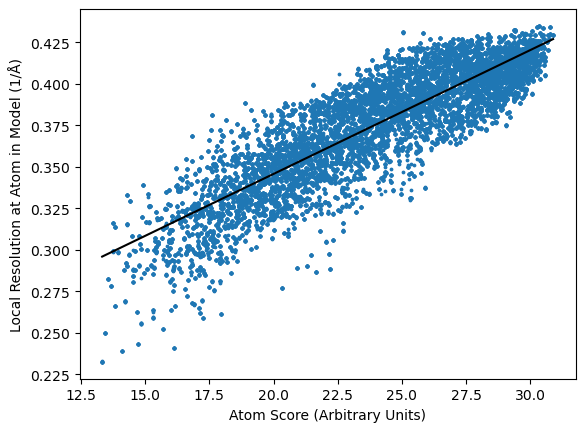

In [ ]:
plot_score_v_localres_byatom('pdbs/out/rubisco_2.pdb', 'pdbs/rubisco_J181.defattr', True)